# Base Line

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


## 1. 데이터 살펴보기

pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [31]:
# 데이터 불러오기
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [32]:
# 학습 데이터에서 라벨 제거하기
y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [33]:
# 학습 데이터와 테스트 데이터 합치기
train_len = len(data) # 추후 착습데이터만 불러오는 인덱스로 활용
data = pd.concat((data, sub), axis=0)

data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.

### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

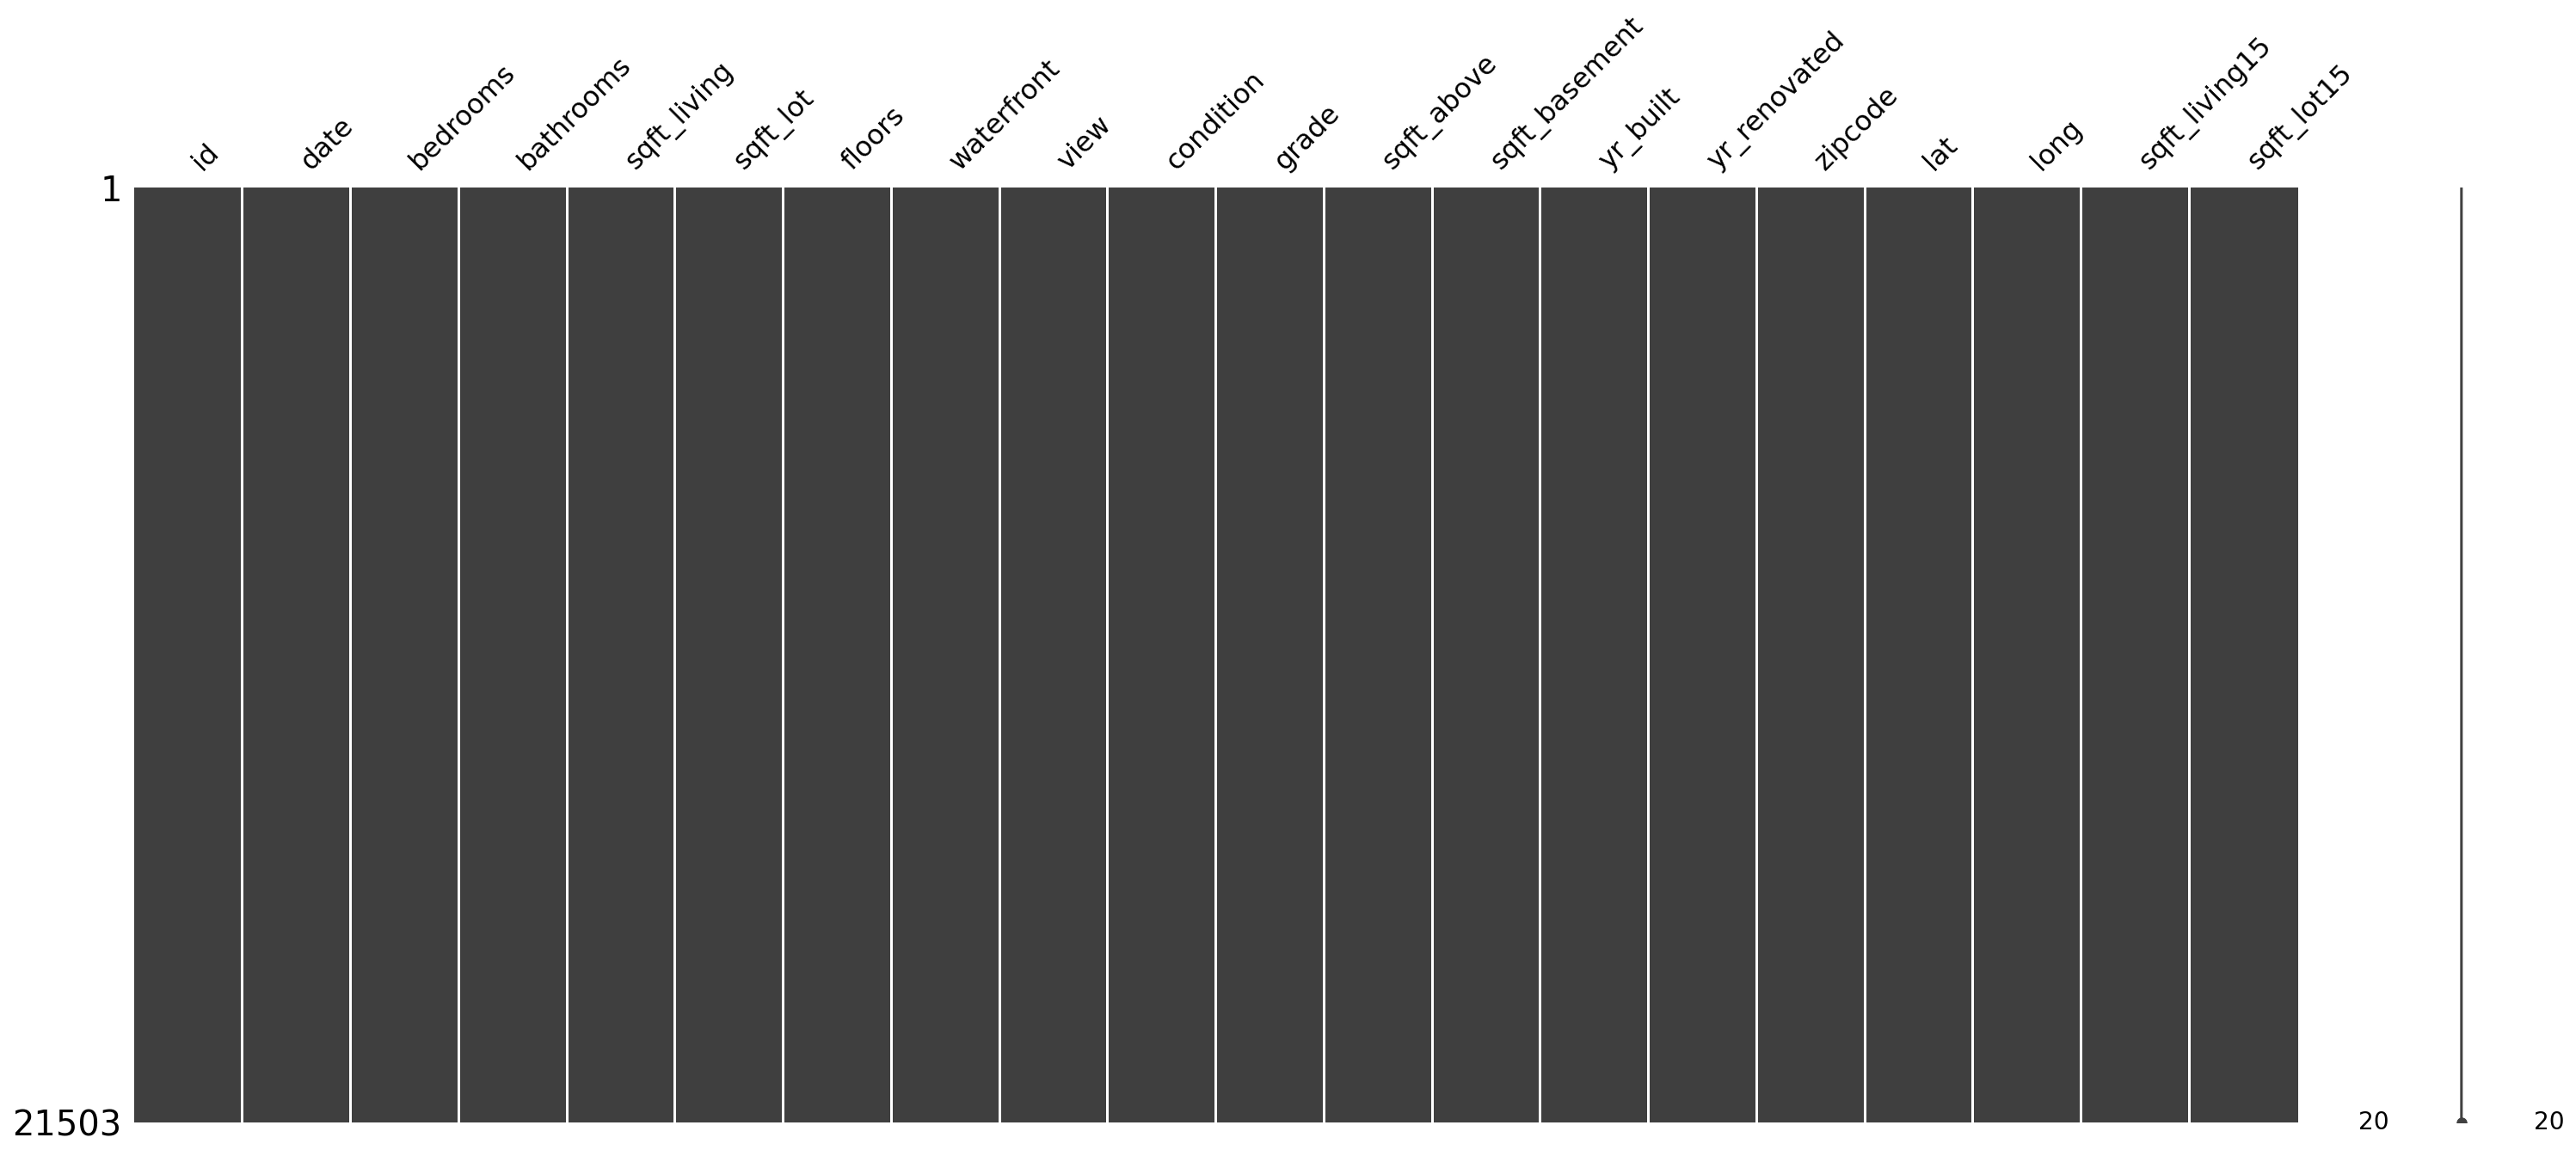

In [34]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [35]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [36]:
for c in data.columns:
    print('{} : {}'.format(c, sum(data[c].isnull()))) # df.isnull() 사용해 결측치 파악

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리

id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [37]:
sub_id = data['id'][train_len:]
del data['id'] # DataFrame.drop
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

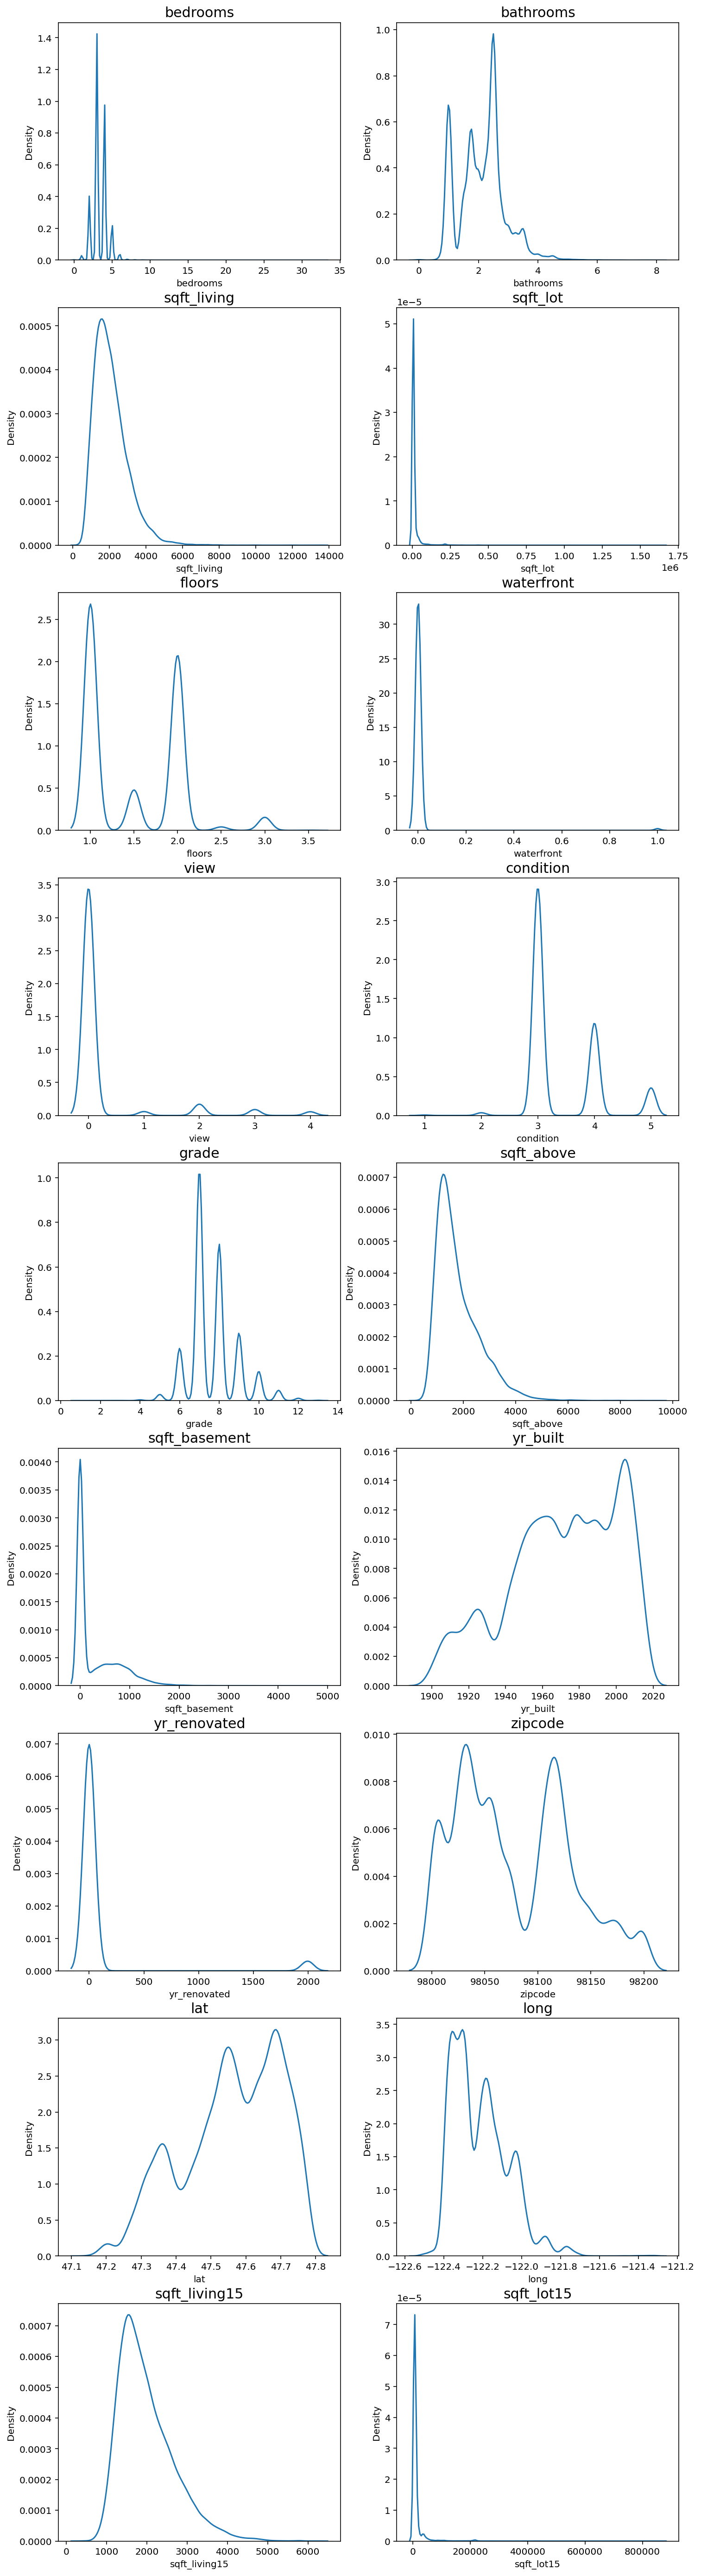

In [38]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [39]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

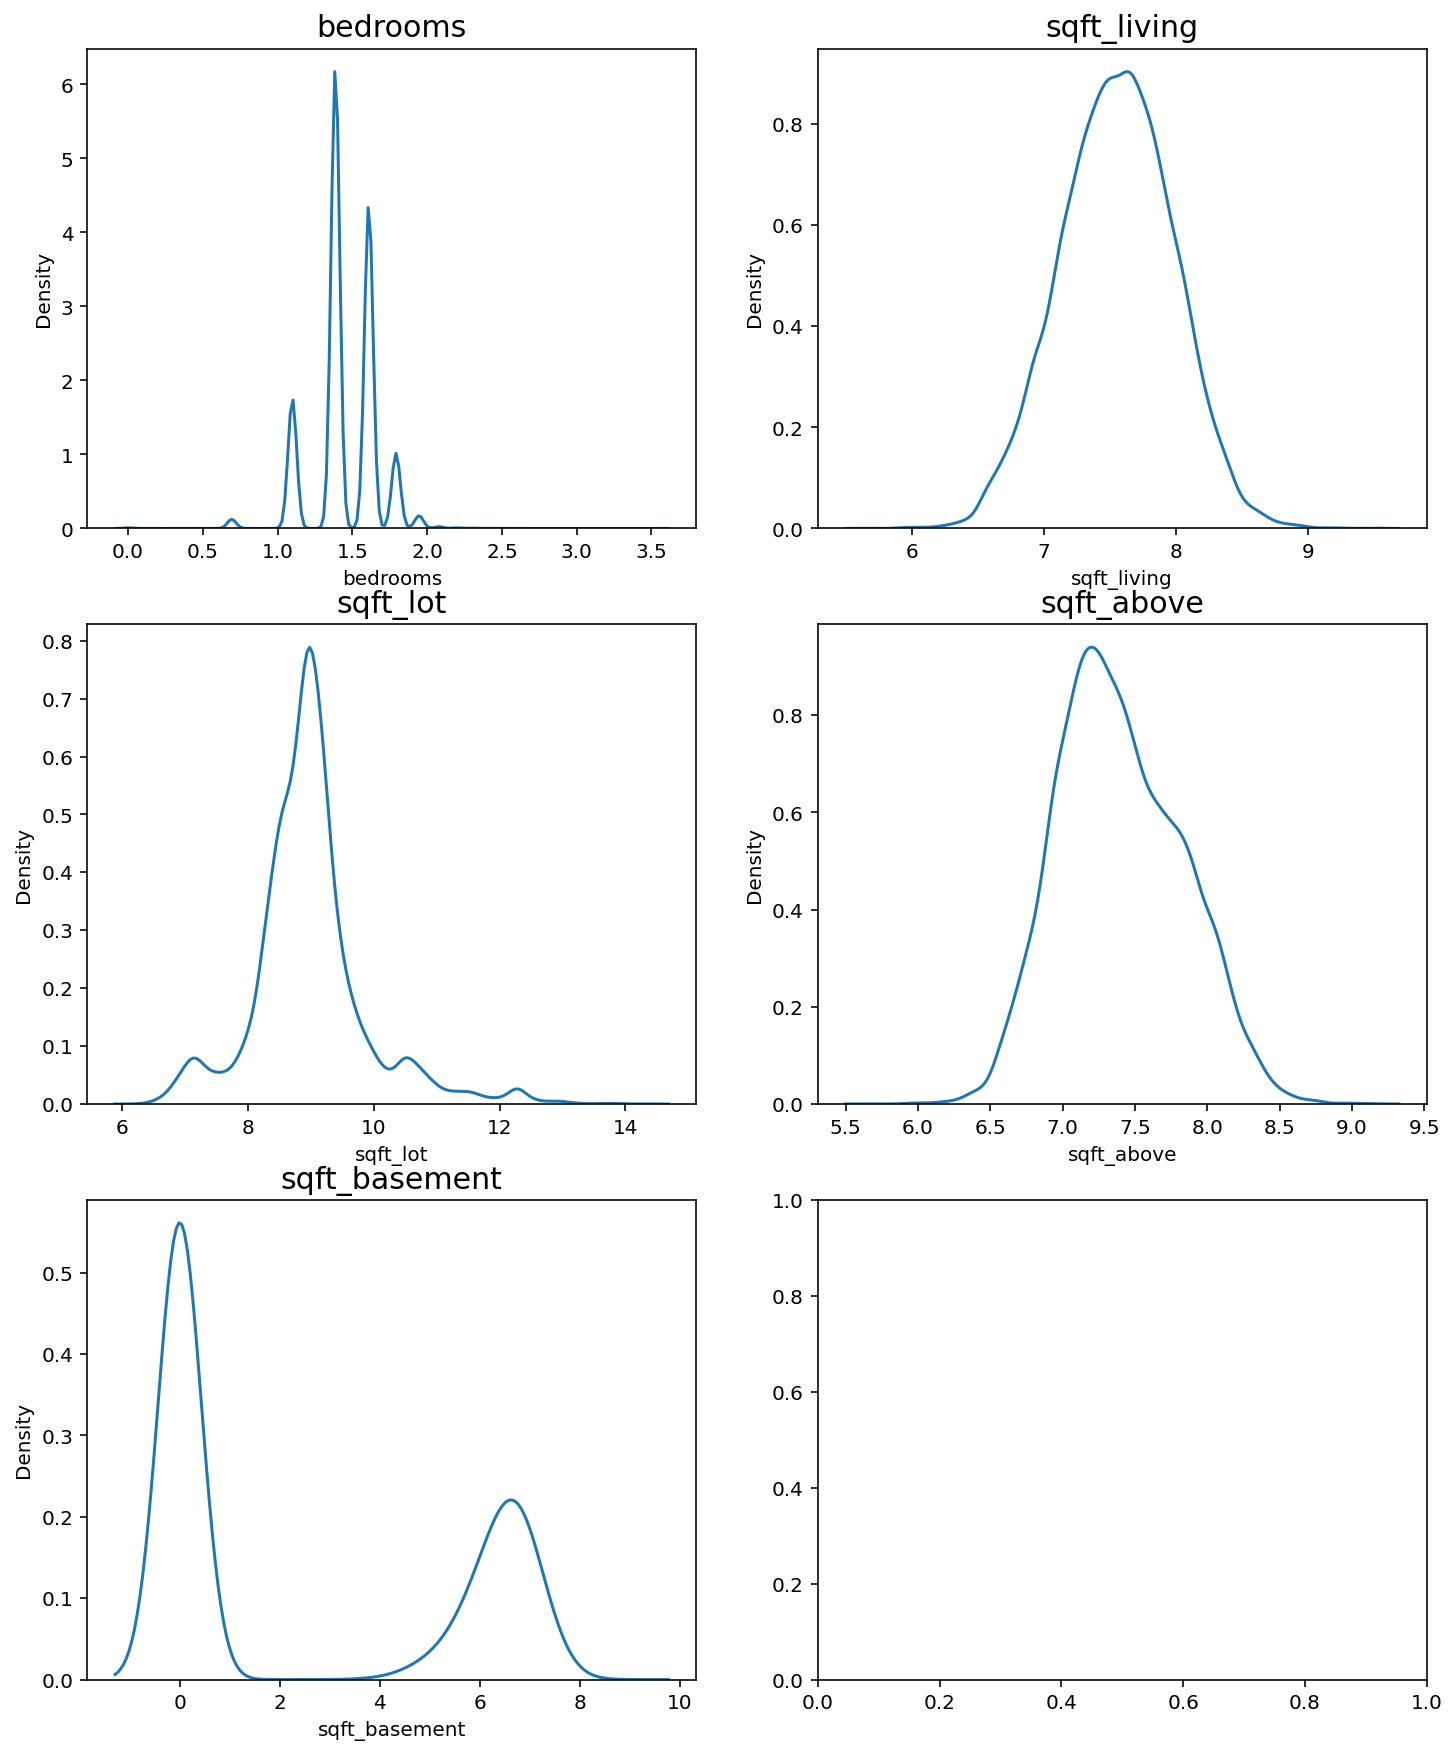

In [40]:
fig, ax = plt.subplots(3, 2, figsize=(12, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

***

### 왜 로그 변환은 분포의 치우침을 줄어들게 만드는 걸까?

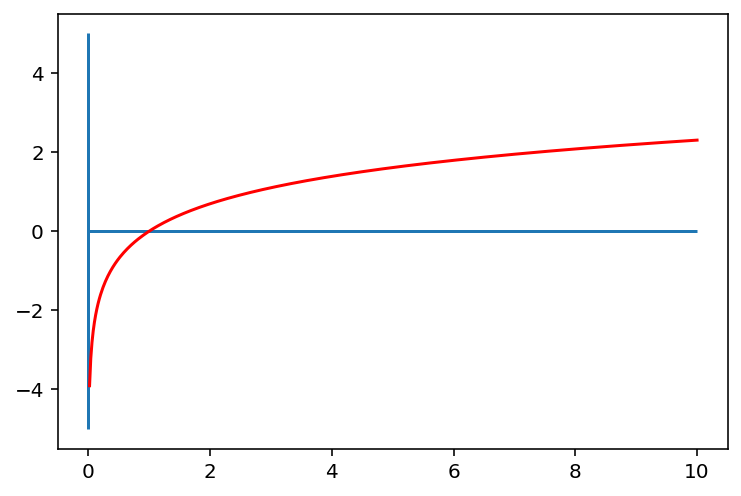

In [41]:
# 로그 함수의 형태를 보면 알 수 있다.
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

- $0<x<1$ 범위에서는 기울기가 매우 가파르다.$x$의 구간은 $(0,1)$로 매우 짧으나 y의 구간은 $(-\inf, 0)$으로 매우 크다
- 0에 가깝게 모여있는 값들이 $x$로 입력되면, 그 함수값인 y값들은 매우 큰 범위로 벌어지게 된다. 즉 로그 함수는 0에 가까운 값들이 조밀하게 모여있는 입력값을 넓은 범위로 펼쳐주는 성질을 가진다.
- 반면, x값이 커짐에 따라 로그 함수의 기울기는 급격히 작아진다. 이는 큰 입력값에 대해서는 y값의 차이가 나지 않게된다는 뜻이며 넓은 범위를 가지는 x를 비교적 작은 값의 구간 내에 모이게 하는 성질을 가진다.
- 위와 같은 성질 때문에 한 쪽으로 몰려있는 분포에 로그 변환을 취하면 정규분포 모양으로 고르게 분포하게 되는 것이다.

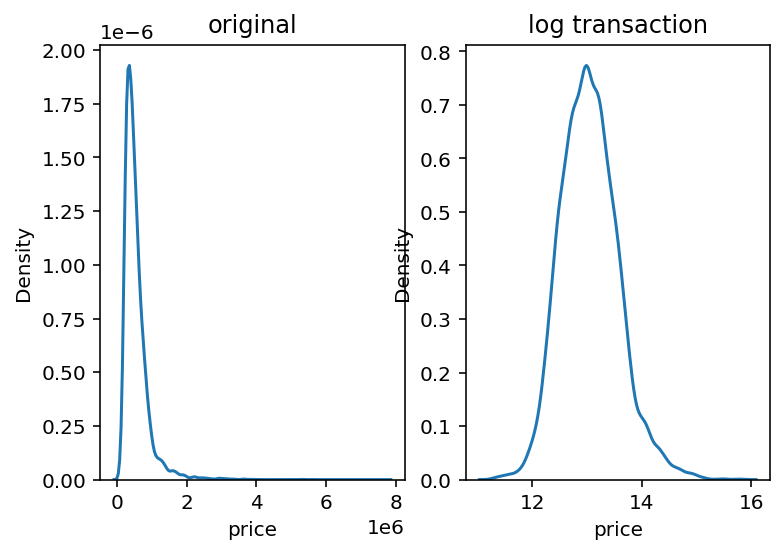

In [42]:
# data[price]의 분포를 예시로 로그 변환을 이해해보자

plt.plot(fig_size=(12,5))
plt.subplot(1,2,1)
plt.title("original")
sns.kdeplot(y)

plt.subplot(1,2,2)
y_log_transformation = np.log1p(y) # 로그변환
plt.title("log transaction")
sns.kdeplot(y_log_transformation)
plt.show()

***

In [43]:
# 전체 데이터 분포를 보기위해 합쳐줬던 데이터셋을 다시 나눠주기
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


## 3. 모델링

### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

> __Blending이란?__<br> 
    <ul> 여러 모델을 종합하여 결과를 얻는 기법으로 앙상블 기법이라고 부르기도 한다.</ul>
    <ul>비정형 데이터의 분류는 딥러닝이 뛰어난 성능을 보이고 있지만, 대부분의 정형 데이터 분류시에는 앙상블이 뛰어난 성능을 나타낸다.</ul>
    [더 알아보기](https://subinium.github.io/introduction-to-ensemble-1/#:~:text=%EC%95%99%EC%83%81%EB%B8%94(Ensemble)%20%ED%95%99%EC%8A%B5%EC%9D%80%20%EC%97%AC%EB%9F%AC,%EB%A5%BC%20%EA%B0%80%EC%A7%80%EA%B3%A0%20%EC%9D%B4%ED%95%B4%ED%95%98%EB%A9%B4%20%EC%A2%8B%EC%8A%B5%EB%8B%88%EB%8B%A4.)

In [44]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [45]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                             kf=kfold))

get_cv_score(models)

Model GradientBoosting CV score : 0.8597
Model XGBoost CV score : 0.8861
Model LightGBM CV score : 0.8819


### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [18]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

y_pred = AveragingBlending(models, x, y, sub)
y_pred

array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

In [19]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [20]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission.csv


# 앞서 제출한 Baseline보다 랭킹을 올려보려면?

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score

import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

## 1. 데이터 준비하기

In [50]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [51]:
# 데이터 살펴보기
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
- date를 년월까지만 표기되도록 슬라이싱 하고 정수형으로 변형
- 타겟 데이터 y 변수에 저장하고 train 데이터에서 제거
- id  컬럼 삭제
- 테스트 데이터에도 위의 작업 반복

In [52]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [53]:
y = train['price'] # 타겟 데이터 분리
del train['price'] # 훈련데이터에서 타겟 컬럼 삭제

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [54]:
del train['id'] # id 컬럼 삭제

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [55]:
# test 데이터에도 동일 작업 진행

test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [56]:
y # 큰 값으로 이루어진 타겟 데이터(y)

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

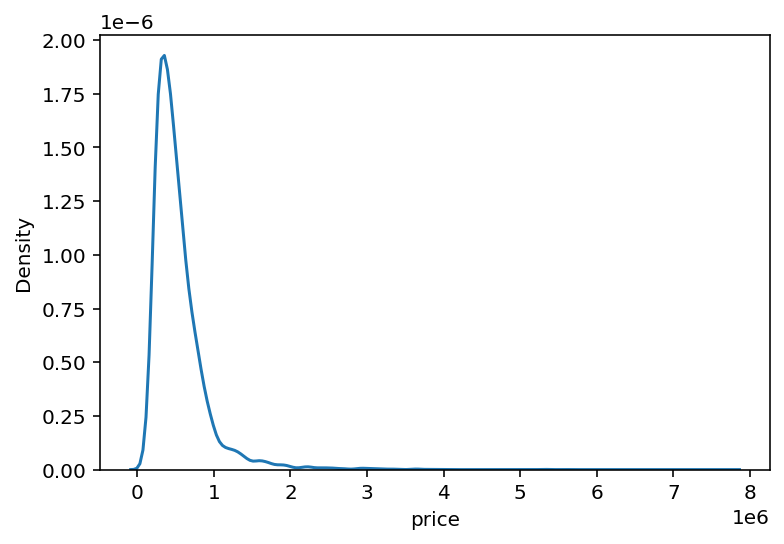

In [57]:
sns.kdeplot(y)
plt.show()

타겟값의 분포가 치우쳐 있으므로 로그 변환하여 scaling 시켜준다.
>  feature scaling : 피처들이 고르게 모델에 영향을 줄 수 있도록 피처의 범위를 조정하는 피처 엔지니어링 과정
1. nl.lo1p() 함수를 통해 로그변환 시행
2. 모델이 값을 예측하고 후에 np.exp1m()을 활용해 원래대로 만들어준다.
- np.exp1m()은 원소마다 $exp(x)-1$ 값을 반환해준다.

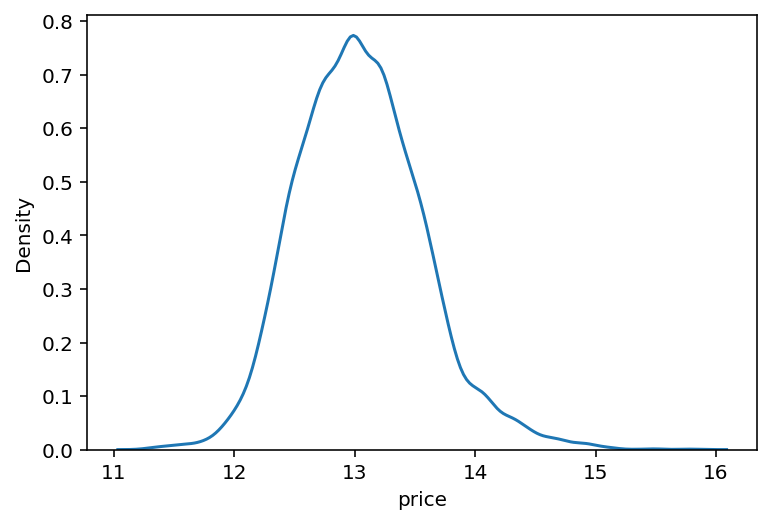

In [58]:
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

In [59]:
# 데이터의 자료형 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

## 3. 다양한 실험을 위해 필요한 작업 함수로 만들기

### RMSE 계산

- log scaling 된 y_test, y_pred 값을 exp를 사용해 원래대로 만들어준다.
- np.sqrt(mean_squared_error()) 

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [61]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
    # y_test, y_pred는 log scaling된 값이므로 exp를 사용해 원래대로 돌려준다

In [62]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [63]:
# 모델 인스턴스 생성
random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [64]:
def get_scores(models, train, y):
    
    df = {}

    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터 셋 분리
        X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=random_state)

        # 모델 학습
        model.fit(X_train, y_train)

        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)

        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

In [65]:
score_df = get_scores(models, train, y)
score_df

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359
XGBRegressor,110318.669566


## 4. Grid Search (하이퍼파라미터 튜닝)

1. GridSearchCV 모델로 `model`을 초기화.
2. 모델을 fitting 한다.
3. params, score에 각 조합에 대한 결과를 저장.
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환.

> __그리드 탐색__<br>
: 사람이 먼저 탐색할 하이퍼파라미터의 값들을 정해두고, 그 값들로 만들어질 수 있는 모든 조합을 탐색한다. 탐색 공간이 제한적이다.

> __랜덤 탐색__<br>
:사람이 탐색할 하이퍼 파라미터의 공간만 정해주고, 그 안에서 램점으로 조합을 선택해서 탐색하는 방법이다. (비교적) 탐색 공간이 넓다

In [66]:
from sklearn.model_selection import GridSearchCV

In [67]:
def my_GridSearch(moel, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV로 모델 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid,
                             scoring='neg_mean_squared_error',
                             cv=5, verbose=1, n_jobs=5)
    # 모델 fitting
    grid_model.fit(train, y)
    
    # params, score에 각 조합에 대한 결과를 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # DataFrame에 점수 저장
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 추가 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score']) # Root Mean Squared Log Error 
    results.sort_values(by=['RMSLE']) # 내림차순으로 정렬
    
    return results

위에서 만든 함수를 이용해 그리드 탐색을 수행한다.

In [24]:
param_grid = {
    'n_estimators': [450, 500, 550, 600, 650, 700],
    'max_depth': [11, 13, 15, 17, 19],
    'num_leaves': [15, 31],
    'learning_rate': [0.02, 0.05 , 0.1, 0.2]
}

lgb_model = LGBMRegressor(random_state=random_state)
result = my_GridSearch(lgb_model, train, y, param_grid, verbose=2, n_jobs=5)
result.sort_values(by=['RMSLE'])

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   14.3s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.2min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  2.7min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  4.5min
[Parallel(n_jobs=5)]: Done 1200 out of 1200 | elapsed:  6.5min finished


,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
83,0.05,13,700,31,-0.025891,0.160908
81,0.05,13,650,31,-0.025917,0.160987
93,0.05,15,650,31,-0.025924,0.161010
95,0.05,15,700,31,-0.025925,0.161013
79,0.05,13,600,31,-0.025928,0.161022
...,...,...,...,...,...,...
36,0.02,17,450,15,-0.028514,0.168860
24,0.02,15,450,15,-0.028514,0.168860
12,0.02,13,450,15,-0.028520,0.168879
227,0.20,17,700,31,-0.028533,0.168918


가장 좋은 조합은learning_rate=0.05, max_depth=13, n_estimators=700, num_leaves=31 이다.

## 5. 제출하기

1. 최적의 조합으로 모델을 구성하고, 모델을  `train`, `y`로 학습시킨다.
2. `test`에 대해 예측한다.
3. 예측값을 `np.expm1`으로 변환하고, `csv` 파일을 저장한다.

In [25]:
def save_submission(model, train, y, test, model_name, rmsle):
    
    # 모델 구성
    model = LGBMRegressor(learning_rate=0.05, max_depth=13, n_estimators=700, num_leaves=31 , random_state=random_state)
    
    # 모델 훈련
    model.fit(train, y)
    
    # 예측
    prediction = model.predict(test)
    
    # 예측값 원래대로 변환
    prediction = np.expm1(prediction)
    
    # 제출파일 불러오기
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    
    # 예측한 값 덮어씌우기
    submission['price'] = prediction
    
    # csv로 저장
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    
    print('{} saved!'.format(submission_csv_path))

In [26]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.1609')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.1609.csv saved!
